In [150]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
df = pd.read_csv('df_after_data_processing.csv')

In [152]:
df.columns.tolist()[:150]

['DOI',
 'Date',
 'Journal',
 'Title',
 'Name',
 'measurement_method',
 'raw_value',
 'smiles',
 'index',
 'atom_stereo_count',
 'atoms',
 'bond_stereo_count',
 'bonds',
 'cactvs_fingerprint',
 'canonical_smiles',
 'charge',
 'complexity',
 'coordinate_type',
 'covalent_unit_count',
 'defined_atom_stereo_count',
 'defined_bond_stereo_count',
 'elements',
 'exact_mass',
 'fingerprint',
 'h_bond_acceptor_count',
 'h_bond_donor_count',
 'heavy_atom_count',
 'inchi',
 'inchikey',
 'isomeric_smiles',
 'isotope_atom_count',
 'iupac_name',
 'molecular_formula',
 'molecular_weight',
 'monoisotopic_mass',
 'record',
 'rotatable_bond_count',
 'tpsa',
 'undefined_atom_stereo_count',
 'undefined_bond_stereo_count',
 'xlogp',
 'index.1',
 'exactmw',
 'amw',
 'lipinskiHBA',
 'lipinskiHBD',
 'NumRotatableBonds',
 'NumHBD',
 'NumHBA',
 'NumHeavyAtoms',
 'NumAtoms',
 'NumHeteroatoms',
 'NumAmideBonds',
 'FractionCSP3',
 'NumRings',
 'NumAromaticRings',
 'NumAliphaticRings',
 'NumSaturatedRings',
 'NumH

Firstly, let's check lipinskiHBA - number of heteroatoms dependence using scatterplot

<AxesSubplot:xlabel='lipinskiHBA', ylabel='NumHeteroatoms'>

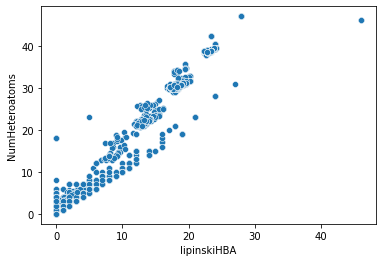

In [153]:
sns.scatterplot(x='lipinskiHBA', y='NumHeteroatoms' ,data=df)

In [154]:
from scipy import stats
stats.pearsonr(df['lipinskiHBA'], df['NumHeteroatoms'])

(0.9879978036920428, 0.0)

As we can see, these descriptors have strong positive correlation

Next, we cal visualize a boxplot of number of atoms in molecules in our dataset

<AxesSubplot:ylabel='NumAtoms'>

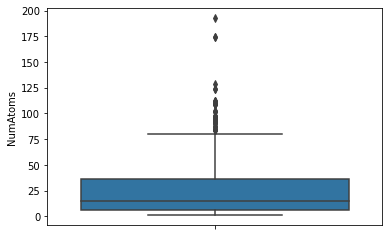

In [155]:
sns.boxplot(data=df, y='NumAtoms')

As we can see our dataset mainly contains small molecules. Also, there are some outliers in this descriptor

We can visualize distribution of molecular weights in our database using histogram plot

<AxesSubplot:xlabel='molecular_weight', ylabel='Count'>

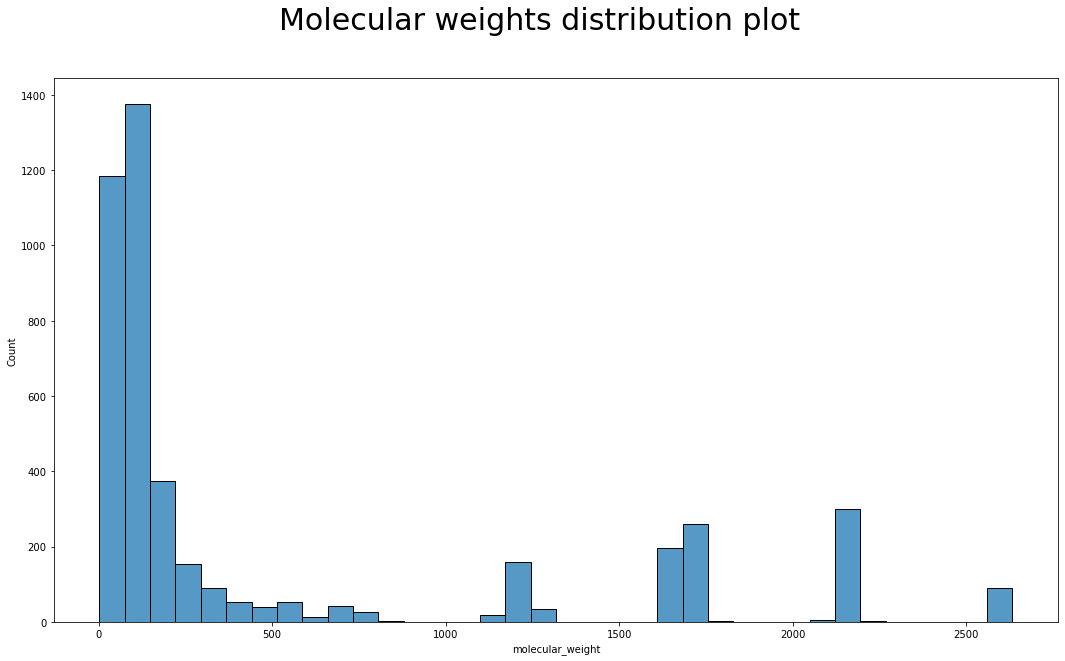

In [214]:
fig, axes = plt.subplots(figsize=(18, 10))

fig.suptitle('Molecular weights distribution plot', size=30)
sns.histplot(data=df, x='molecular_weight')

As we can see, distribution of molecular weights shifted to the small values (because our dataset dominated by small molecules)

Next, we can use plotly to build interactive visualizations

In [157]:
import plotly.graph_objects as go
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output 

In [158]:
fig = px.scatter(df, x='CrippenClogP', y='xlogp', size='NumAtoms', size_max=25)
 # build jupyter dash app
app = JupyterDash(__name__)
 # add html components and figure to app
app.layout = html.Div([dcc.Graph(figure=fig)])
 # run app inline
app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



As we can see, small molecules have the approximately the same distribution between octanol and water while large molecules tend to be hydrophilic or hydrophobic. It should be mentioned, that for hydrophobic molecules there is correspondence between two different calculation approaches for obtaining logP value, however for more hydrophilic molecules there is not any compliance between two methods.

As we can see, plots can be useful for understanding distribution of parameters in our dataset or investigation of dependiences between them.

Next, let's take some statistical tests on our data

In [159]:
from scipy.stats import shapiro
data = df['NumAtoms']
stat, p = shapiro(data)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.854, p=0.000
Probably not Gaussian


<AxesSubplot:xlabel='NumAtoms', ylabel='Count'>

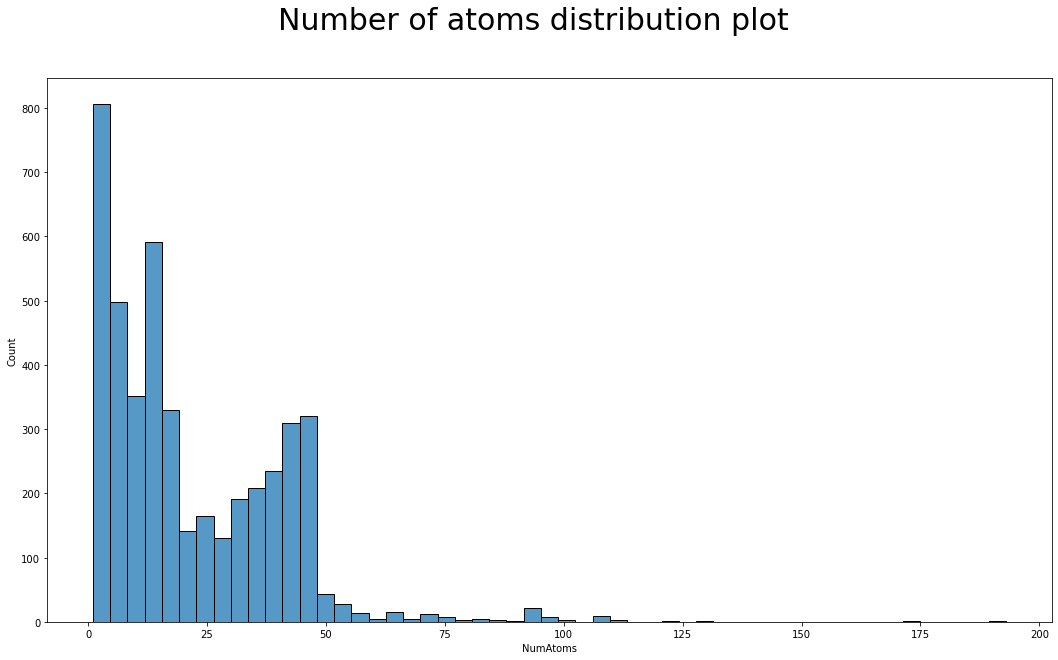

In [160]:
fig, axes = plt.subplots(figsize=(18, 10))

fig.suptitle('Number of atoms distribution plot', size=30)
sns.histplot(data=df, x='NumAtoms')

Our distribution is not Gaussian with data shift towards small molecules

Next we can check, do the molecular weight and number of atoms have the same distribution

In [161]:
from scipy.stats import ttest_ind
data1 = df['molecular_weight']
data2 = df['NumAtoms']
stat, p = ttest_ind(data1, data2)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=45.641, p=0.000
Probably different distributions


They have different distribution because of presence of heavy atoms in our molecules 

Let's check distributions of number H acceptors and lipinski HBA (number of Os and Ns)

In [162]:
from scipy.stats import ttest_ind
data1 = df['h_bond_acceptor_count']
data2 = df['lipinskiHBA']
stat, p = ttest_ind(data1, data2)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=0.944, p=0.345
Probably the same distribution


<AxesSubplot:xlabel='lipinskiHBA', ylabel='Count'>

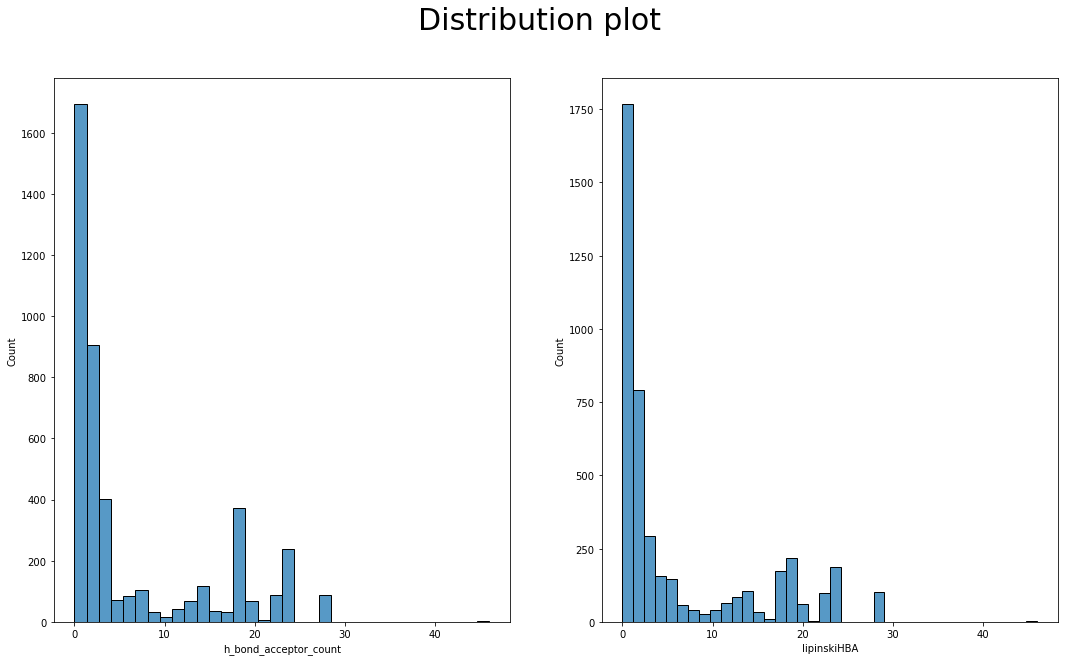

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

fig.suptitle('Distribution plot', size=30)
sns.histplot(ax=axes[0], data=df, x='h_bond_acceptor_count')
sns.histplot(ax=axes[1], data=df, x='lipinskiHBA')

We can conclude that the main atoms that are acceptors of hydrogen in our database are nitrogen and oxygen

It is interesting to investigane distributions of logP values obtained by different calculation methods

In [167]:
from scipy.stats import f_oneway
data1 = df['xlogp']
data2 = df['CrippenClogP']
data3 = df['ALogP']
stat, p = f_oneway(data1, data2)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=1333.643, p=0.000
Probably different distributions


<AxesSubplot:xlabel='ALogP', ylabel='Count'>

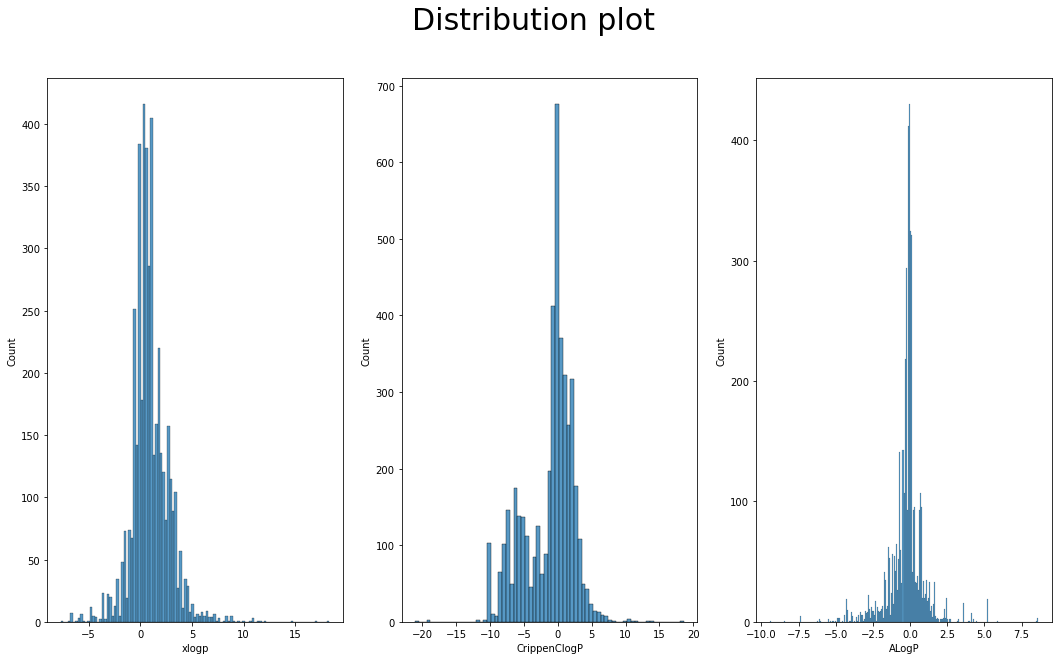

In [168]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

fig.suptitle('Distribution plot', size=30)
sns.histplot(ax=axes[0], data=df, x='xlogp')
sns.histplot(ax=axes[1], data=df, x='CrippenClogP')
sns.histplot(ax=axes[2], data=df, x='ALogP')

So, they do not have similar distrubution

Let's translate CrippenClogP from numerical to categorical values

In [179]:
for i,_ in df.iterrows():
    if df['CrippenClogP'][i] < 0:
        df['CrippenClogP'][i] = 'Hydrophilic'
    elif df['CrippenClogP'][i] > 0:
        df['CrippenClogP'][i] = 'Hydrophobic'
    elif df['CrippenClogP'][i] == 0:
        df['CrippenClogP'][i] = 'Superposition'

/tmp/ipykernel_44/4079677703.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Do some interesting statistics

Hydrophilic v.s. Hydrophobic: t-test independent samples with Bonferroni correction, P_val=5.201e-208 stat=3.249e+01


(<AxesSubplot:xlabel='CrippenClogP', ylabel='h_bond_acceptor_count'>,
 [<statannot.StatResult.StatResult at 0x7fe1d4f23d60>])

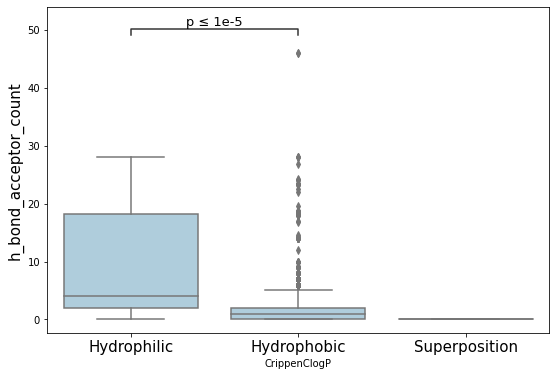

In [211]:
from statannot import add_stat_annotation
f, g = plt.subplots(figsize=(9, 6))
g = sns.boxplot(x='CrippenClogP', y='h_bond_acceptor_count', data=df, color='#A7D0E4')
g.set_ylabel( r'h_bond_acceptor_count', fontsize = 15)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15)
add_stat_annotation(g, data=df, x='CrippenClogP', y='h_bond_acceptor_count',
                    box_pairs=[('Hydrophobic', 'Hydrophilic')],
                    test='t-test_ind', text_format='simple', loc='inside', verbose=2, fontsize = 13, comparisons_correction='bonferroni')

As we can see, there is significant difference in number of h acceptors between hydrophilic and hydrophobic molecules

Hydrophilic v.s. Hydrophobic: t-test independent samples with Bonferroni correction, P_val=1.889e-274 stat=3.804e+01


(<AxesSubplot:xlabel='CrippenClogP', ylabel='kappa1'>,
 [<statannot.StatResult.StatResult at 0x7fe1d37dc490>])

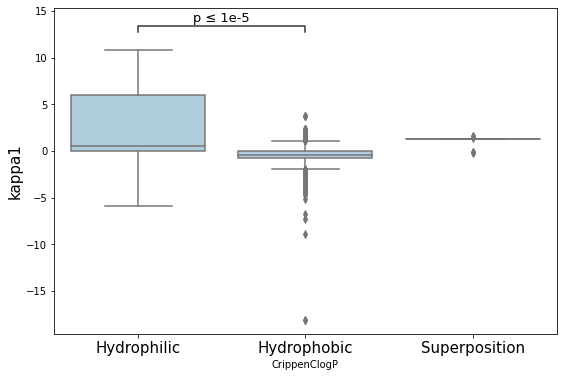

In [222]:
from statannot import add_stat_annotation
f, g = plt.subplots(figsize=(9, 6))
g = sns.boxplot(x='CrippenClogP', y='hallKierAlpha', data=df, color='#A7D0E4')
g.set_ylabel( r'hallKierAlpha', fontsize = 15)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15)
add_stat_annotation(g, data=df, x='CrippenClogP', y='hallKierAlpha',
                    box_pairs=[('Hydrophobic', 'Hydrophilic')],
                    test='t-test_ind', text_format='simple', loc='inside', verbose=2, fontsize = 13, comparisons_correction='bonferroni')

What is more interesting that complexity of the structure is different for hydrophobic and hydrophilic molecules in our dataset. 
More branched molecules are hydrophobic